In [1]:
setwd(paste0(Sys.getenv('ROOT'), '/R'))

In [24]:
source('main.R')

data <- kaggle.house$loadData()

df.combined <- 
    kaggle.house$getCombinedDataset(data$train, data$test) %>% 
    (kaggle.house$na$fixAll) %>%
    (kaggle.house$outliers$removeOutliers) %>%
    mutate(price.log = log(SalePrice)) %>%
    select(-SalePrice) 

df.combined.final <- df.combined %>% (kaggle.house$trans$transformCombindedDataset)

trainset <- 
    df.combined.final %>% 
    filter(dataSource == "train") %>%
    select(-dataSource, -Id) %>%
    mutate(
        price = exp(price.log),
        sq.feat.price = price / GrLivArea,
        log.area = log(GrLivArea)
    )

testset <- 
    df.combined.final %>% 
    filter(dataSource == "test") %>%
    select(-dataSource, -Id,  -price.log)

trainset %>% colnames

setdiff(trainset %>% colnames, testset %>% colnames)
setdiff(testset %>% colnames, trainset %>% colnames) %>% length

[1] "LotFrontage"   "LotArea"       "Street"        "Alley"        
 [5] "LotShape"      "LandContour"   "Utilities"     "LandSlope"    
 [9] "OverallQual"   "OverallCond"   "YearBuilt"     "YearRemodAdd" 
[13] "RoofMatl"      "MasVnrArea"    "BsmtFinSF1"    "BsmtFinSF2"   
[17] "BsmtUnfSF"     "TotalBsmtSF"   "Heating"       "CentralAir"   
[21] "Electrical"    "X1stFlrSF"     "X2ndFlrSF"     "LowQualFinSF" 
[25] "GrLivArea"     "BsmtFullBath"  "BsmtHalfBath"  "FullBath"     
[29] "HalfBath"      "BedroomAbvGr"  "KitchenAbvGr"  "TotRmsAbvGrd" 
[33] "Functional"    "Fireplaces"    "GarageYrBlt"   "GarageCars"   
[37] "GarageArea"    "PavedDrive"    "WoodDeckSF"    "OpenPorchSF"  
[41] "EnclosedPorch" "X3SsnPorch"    "ScreenPorch"   "PoolArea"     
[45] "PoolQC"        "MiscFeature"   "MiscVal"       "MoSold"       
[49] "YrSold"        "price.log"     "BldgType"      "BsmtCond"     
[53] "BsmtExposure"  "BsmtFinType1"  "BsmtFinType2"  "BsmtQual"     
[57] "Condition1"    "Condition2"    "ExterCond"     "Exterior1st"  
[61] "Exterior2nd"   "ExterQual"     "Fence"         "FireplaceQu"  
[65] "Foundation"    "GarageCond"    "GarageFinish"  "GarageQual"   
[69] "GarageType"    "HeatingQC"     "HouseStyle"    "KitchenQual"  
[73] "LotConfig"     "MasVnrType"    "MSSubClass"    "MSZoning"     
[77] "Neighborhood"  "RoofStyle"     "SaleCondition" "SaleType"     
[81] "price"         "sq.feat.price" "log.area"

[1] "price.log"     "price"         "sq.feat.price" "log.area"

[1] 0

In [25]:
combine.levels.OverallQual <- function (df) {
    df %>%
    mutate(
        quality = case_when(
            OverallQual %in% c(1, 2, 3, 4) ~ 1,
            OverallQual %in% c(9, 10) ~ 6,
            TRUE ~ OverallQual - 3
        )
    )
}

trainset <- trainset %>% (combine.levels.OverallQual)

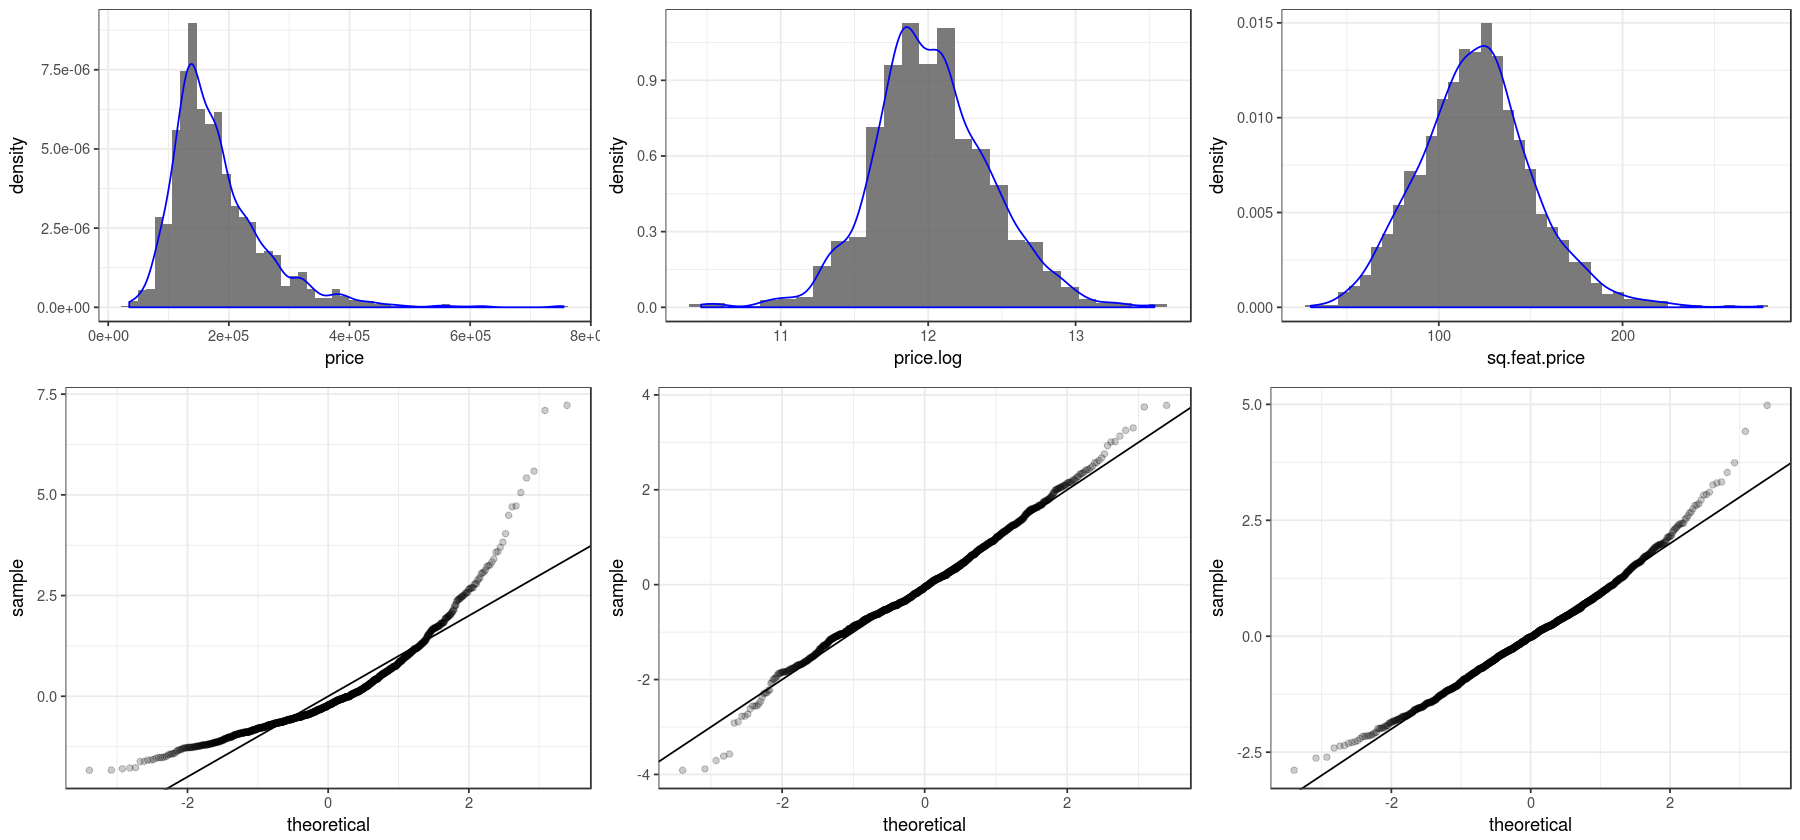

In [27]:
p1 <- trainset %>% 
    ggplot(aes(price)) +
    geom_histogram(aes(y=..density..), binwidth=14e3, alpha=0.8) +
    geom_density(color="blue") +
    theme_bw()

p2 <- trainset %>% 
    ggplot(aes(price.log)) +
    geom_histogram(aes(y=..density..), binwidth=0.12, alpha=0.8) +
    geom_density(color="blue") +
    theme_bw()

p3 <- trainset %>% 
    ggplot(aes(sq.feat.price)) +
    geom_histogram(aes(y=..density..), binwidth=6, alpha=0.8) +
    geom_density(color="blue") +
    theme_bw()

qq1 <- trainset %>% 
    mutate(price.norm = (price - mean(price)) / sd(price)) %>%
    ggplot() +
    geom_qq(aes(sample=price.norm), alpha=0.2) +
    geom_abline(slope=1) +
    theme_bw()

qq2 <- trainset %>% 
    mutate(
        price.log.norm = (price.log - mean(price.log)) / sd(price.log)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=price.log.norm), alpha=0.2) +
    geom_abline(slope=1) +
    theme_bw()

qq3 <- trainset %>% 
    mutate(
        sq.feat.price.norm = (sq.feat.price - mean(sq.feat.price)) / sd(sq.feat.price)
    ) %>%
    ggplot() +
    geom_qq(aes(sample=sq.feat.price.norm), alpha=0.2) +
    geom_abline(slope=1) +
    theme_bw()

options(repr.plot.width = 15, repr.plot.height = 7)

x <- grid.arrange(p1, p2, p3, qq1, qq2, qq3, 
                  layout_matrix=rbind(c(1, 2, 3), 
                                      c(4, 5, 6)),
                 heights=c(45, 55))

In [30]:
log.price.vs.vars <- 
    trainset %>%
    gather(var.name, var.value, -price, -price.log, -sq.feat.price) %>%
    group_by(var.name) %>%
    nest %>% 
    mutate(
        mod = map(data, ~lm(price ~ var.value, .)),
        glance = map(mod, broom::glance),
        r2 = map_dbl(glance, 'r.squared'),
        
        mod.log = map(data, ~lm(price.log ~ var.value, .)),
        glance.log = map(mod.log, broom::glance),
        r2.log = map_dbl(glance.log, 'r.squared'),
        
        mod.sq.feat = map(data, ~lm(sq.feat.price ~ var.value, .)),
        glance.sq.feat = map(mod.sq.feat, broom::glance),
        r2.sq.feat = map_dbl(glance.sq.feat, 'r.squared')
    ) %>%
    select(var.name, r2, r2.log, r2.sq.feat) %>%
    mutate_if(is.numeric, funs(round(., 3)))

log.price.vs.vars %>% arrange(desc(r2)) %>% head(12) %>% t
log.price.vs.vars %>% arrange(desc(r2.log)) %>% head(12) %>% t
log.price.vs.vars %>% arrange(desc(r2.sq.feat)) %>% head(12) %>% t

[,1]        [,2]    [,3]      [,4]         [,5]     [,6]     
var.name   OverallQual quality GrLivArea Neighborhood log.area ExterQual
r2         0.633       0.621   0.540     0.523        0.494    0.471    
r2.log     0.675       0.657   0.526     0.572        0.544    0.466    
r2.sq.feat 0.240       0.234   0.007     0.292        0.011    0.250    
           [,7]     [,8]        [,9]        [,10]      [,11]     [,12]     
var.name   BsmtQual KitchenQual TotalBsmtSF GarageCars X1stFlrSF GarageArea
r2         0.454    0.446       0.424       0.411      0.399     0.396     
r2.log     0.455    0.451       0.419       0.464      0.385     0.431     
r2.sq.feat 0.302    0.244       0.229       0.166      0.093     0.170

[,1]        [,2]    [,3]         [,4]     [,5]      [,6]     
var.name   OverallQual quality Neighborhood log.area GrLivArea ExterQual
r2         0.633       0.621   0.523        0.494    0.540     0.471    
r2.log     0.675       0.657   0.572        0.544    0.526     0.466    
r2.sq.feat 0.240       0.234   0.292        0.011    0.007     0.250    
           [,7]       [,8]     [,9]        [,10]      [,11]       [,12]    
var.name   GarageCars BsmtQual KitchenQual GarageArea TotalBsmtSF X1stFlrSF
r2         0.411      0.454    0.446       0.396      0.424       0.399    
r2.log     0.464      0.455    0.451       0.431      0.419       0.385    
r2.sq.feat 0.166      0.302    0.244       0.170      0.229       0.093

[,1]      [,2]     [,3]         [,4]      [,5]        [,6]       
var.name   YearBuilt BsmtQual Neighborhood ExterQual KitchenQual OverallQual
r2         0.274     0.454    0.523        0.471     0.446       0.633      
r2.log     0.345     0.455    0.572        0.466     0.451       0.675      
r2.sq.feat 0.317     0.302    0.292        0.250     0.244       0.240      
           [,7]    [,8]        [,9]         [,10]        [,11]      [,12]     
var.name   quality TotalBsmtSF BsmtFinType1 YearRemodAdd BsmtFinSF1 Foundation
r2         0.621   0.424       0.209        0.258        0.168      0.255     
r2.log     0.657   0.419       0.228        0.320        0.154      0.304     
r2.sq.feat 0.234   0.229       0.214        0.208        0.201      0.187

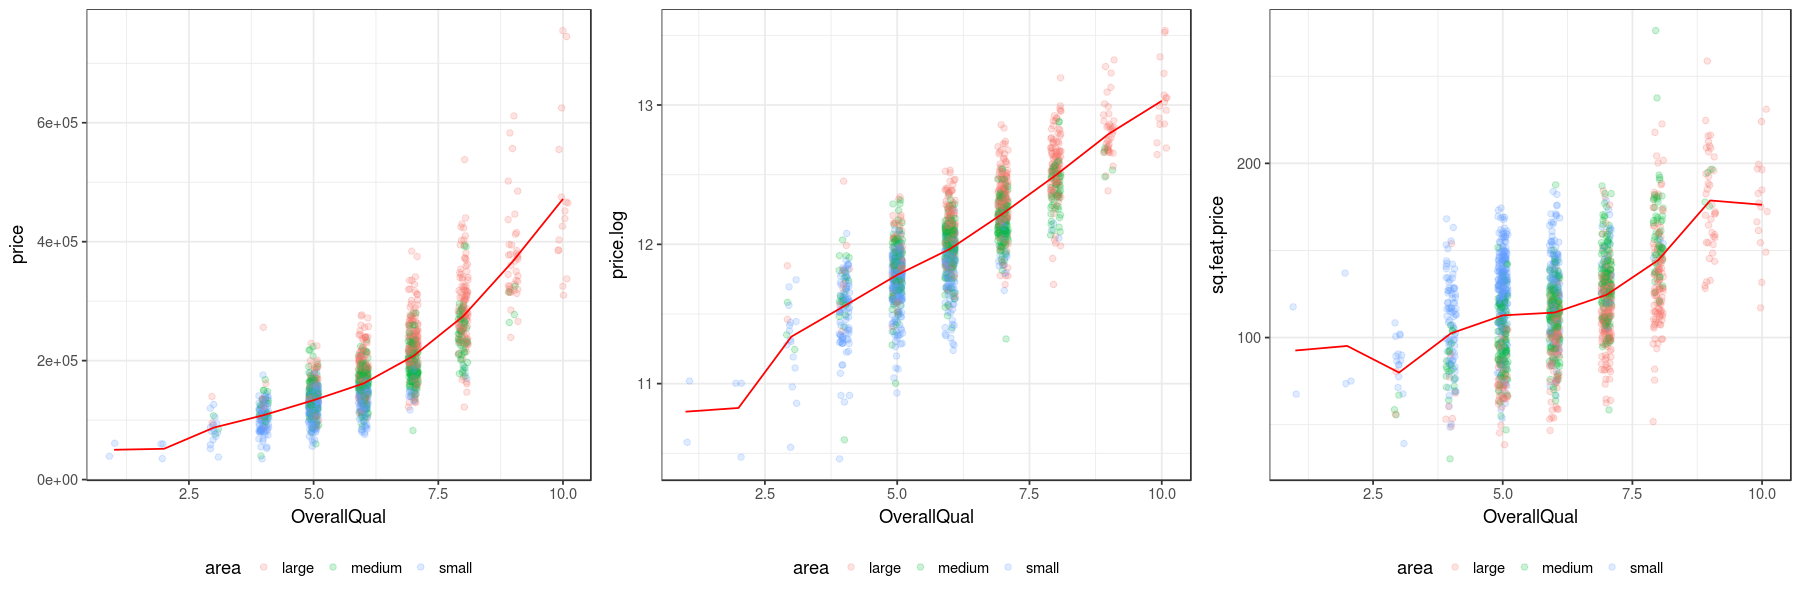

In [32]:
df <- 
    trainset %>%
    mutate(
        area = case_when(
            GrLivArea <= quantile(GrLivArea, 0.33) ~ 'small',
            GrLivArea > quantile(GrLivArea, 0.33)  & 
                GrLivArea < quantile(GrLivArea, 0.66)~ 'medium',
            TRUE ~ 'large'
        )
    )

p1 <- 
    df %>%
    ggplot(aes(x=OverallQual, y=price)) +
    geom_jitter(aes(color=area), alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p2 <- 
    df %>%
    ggplot(aes(x=OverallQual, y=price.log)) +
    geom_jitter(aes(color=area), alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p3 <-
    df %>%
    ggplot(aes(x=OverallQual, y=sq.feat.price)) +
    geom_jitter(aes(color=area), alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

options(repr.plot.width = 15, repr.plot.height = 5)

grid.arrange(p1, p2, p3, layout_matrix=rbind(c(1, 2, 3)))

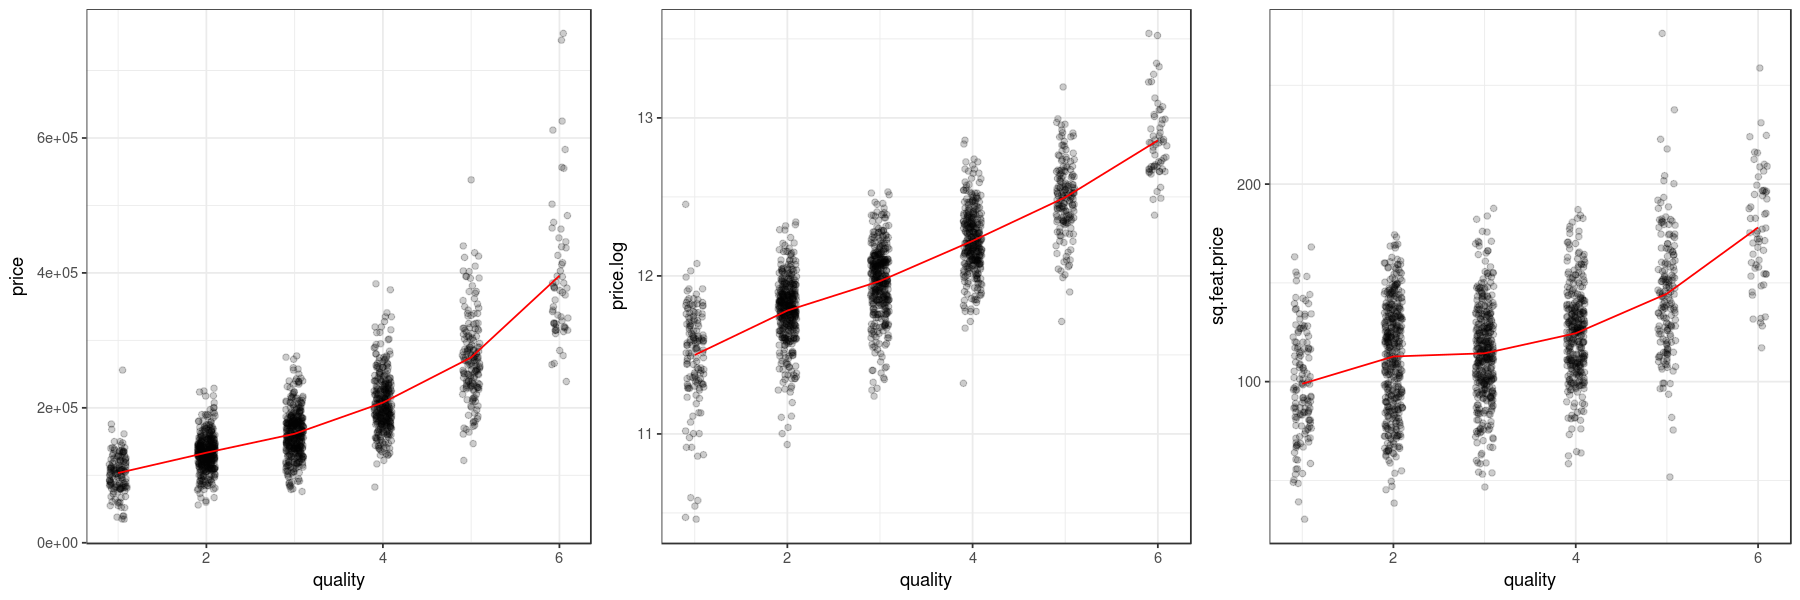

In [33]:
p1 <- 
    trainset %>%
    ggplot(aes(x=quality, y=price)) +
    geom_jitter(alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p2 <- 
    trainset %>%
    ggplot(aes(x=quality, y=price.log)) +
    geom_jitter(alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

p3 <-
    trainset %>%
    ggplot(aes(x=quality, y=sq.feat.price)) +
    geom_jitter(alpha=0.2, width=0.1, height=0) +
    stat_summary(fun.y = mean, geom="line", colour = "red") +
    theme_bw() +
    theme(legend.position="bottom")

options(repr.plot.width = 15, repr.plot.height = 5)

grid.arrange(p1, p2, p3, layout_matrix=rbind(c(1, 2, 3)))

[[1]]
  r.squared adj.r.squared     sigma statistic p.value df   logLik       AIC
1 0.6565905     0.6563546 0.2343183  2783.836       0  2 47.85559 -89.71117
        BIC deviance df.residual
1 -73.85671 79.94176        1456

[[2]]
  r.squared adj.r.squared     sigma statistic p.value df   logLik       AIC
1 0.6600165     0.6595491 0.2332266  1412.309       0  3 55.16486 -102.3297
        BIC deviance df.residual
1 -81.19043 79.14423        1455

[[3]]
  r.squared adj.r.squared     sigma statistic p.value df   logLik       AIC
1  0.662206     0.6615091 0.2325543  950.1329       0  4 59.87494 -109.7499
        BIC deviance df.residual
1 -83.32578 78.63453        1454

[[1]]
         term   estimate   std.error statistic p.value
1 (Intercept) 11.2511479 0.015881523 708.44261       0
2     quality  0.2489134 0.004717658  52.76207       0

[[2]]
         term   estimate   std.error  statistic      p.value
1 (Intercept) 11.3630041 0.033215016 342.104430 0.000000e+00
2     quality  0.1682582 0.021580926   7.796615 1.203635e-14
3    quality2  0.0122278 0.003193405   3.829078 1.340868e-04

[[3]]
          term     estimate  std.error   statistic      p.value
1  (Intercept) 11.124122382 0.04585290 242.6045752 0.000000e+00
2      quality  0.277523760 0.01300282  21.3433587 3.802987e-88
3  quality.low  0.100577741 0.02607960   3.8565675 1.200134e-04
4 quality.high  0.006930867 0.02939106   0.2358154 8.136091e-01

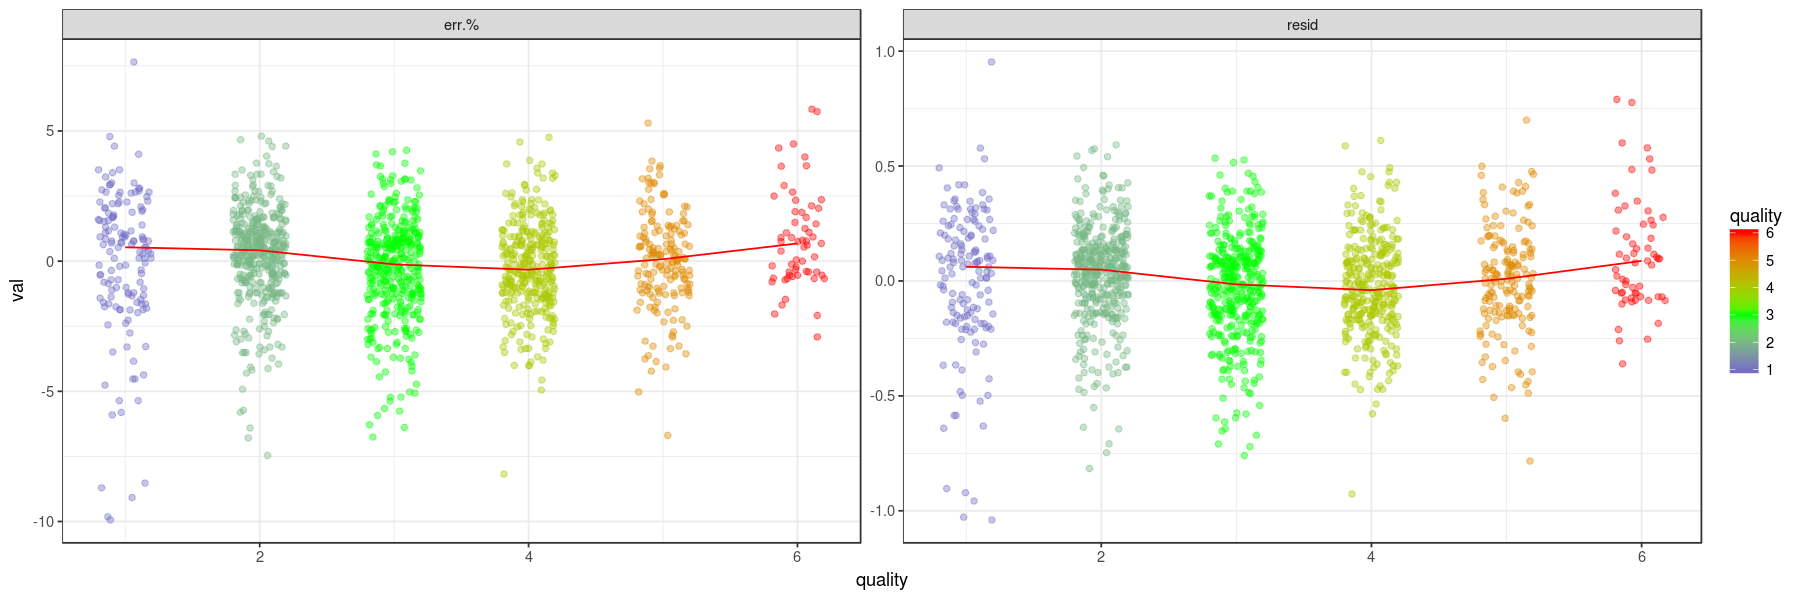

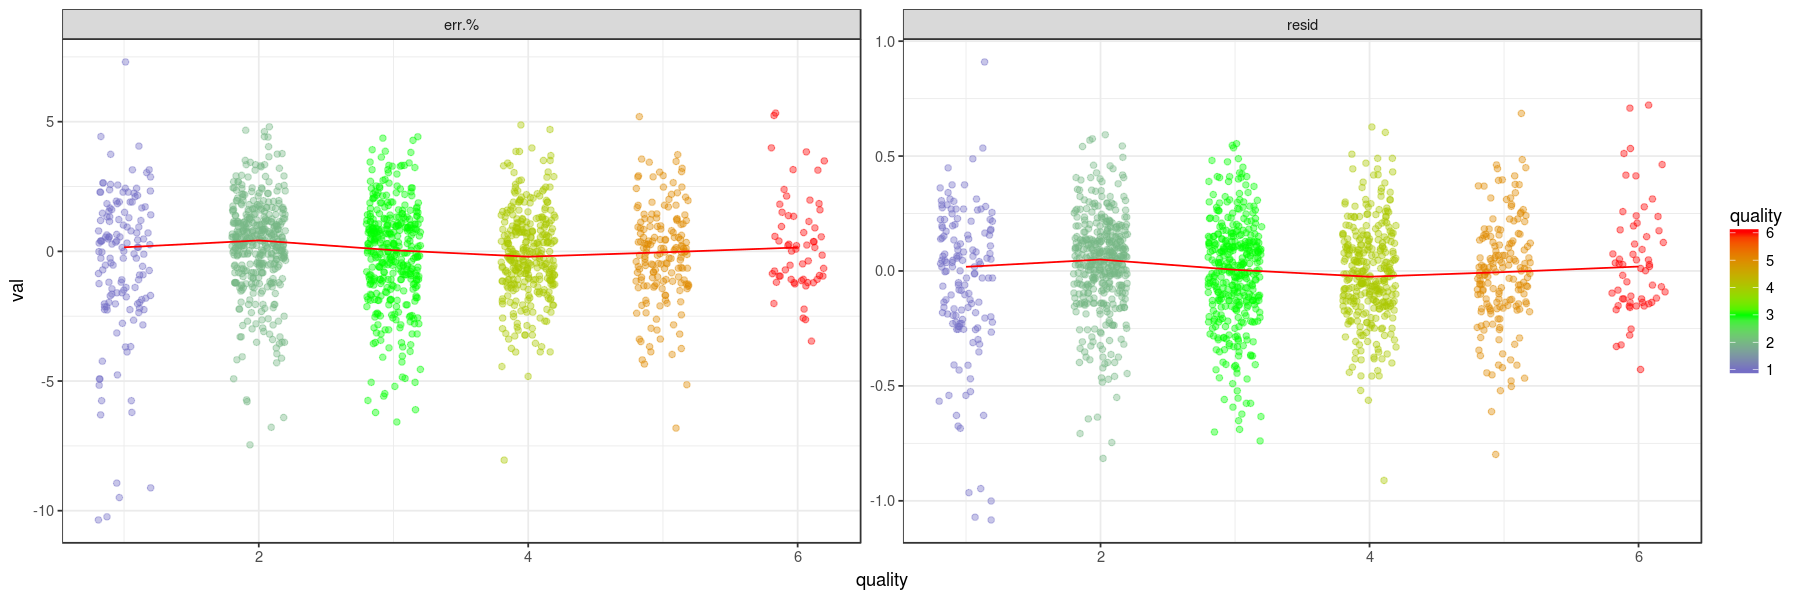

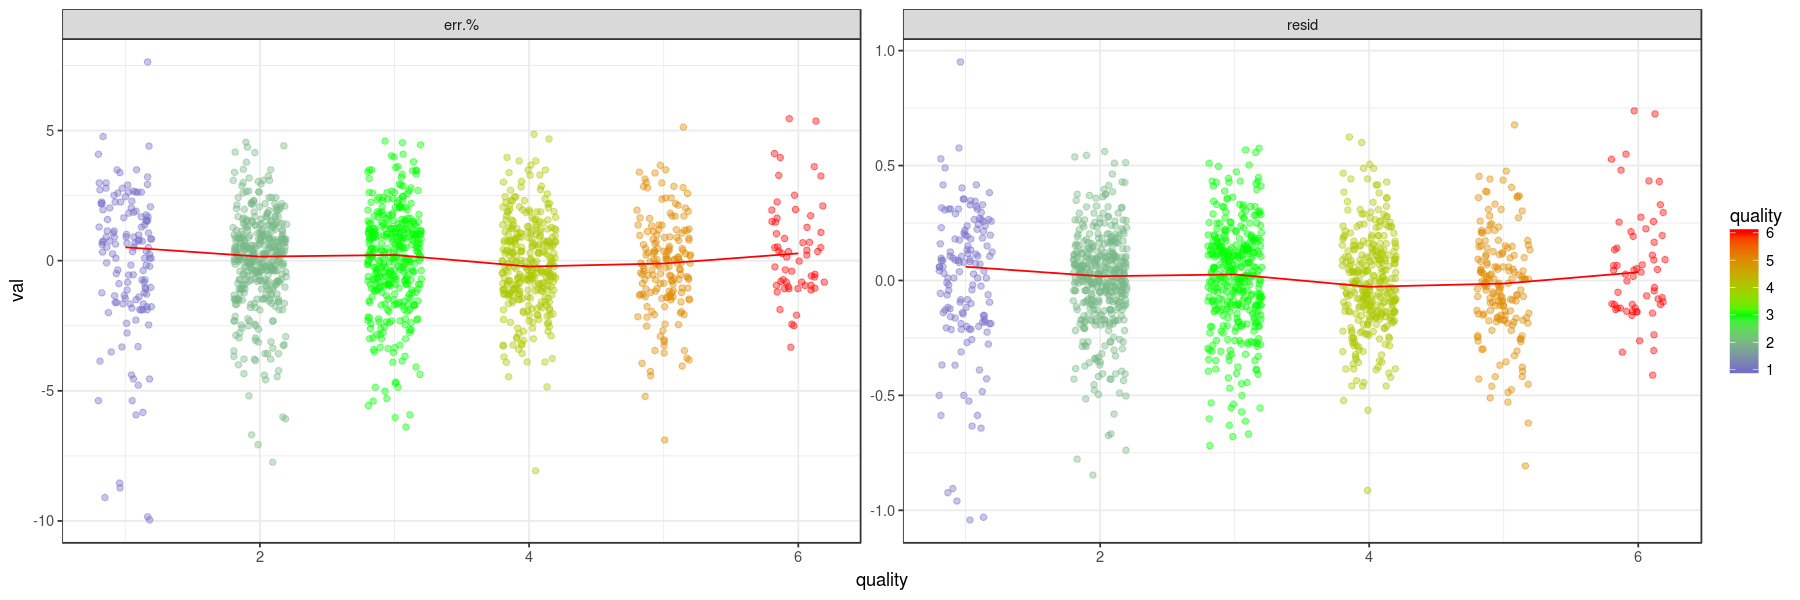

In [36]:
mod <- list()

mod[[1]] <- lm(price.log ~ quality, 
             data=trainset)

mod[[2]] <- lm(price.log ~ quality + quality2, 
             data=trainset %>% mutate(quality2 = quality^2))

mod[[3]] <- lm(price.log ~ quality + quality.low + quality.high, 
             data=trainset %>% 
                  mutate(
                      quality.low = ifelse(quality <= 2, 1, 0),
                      quality.high = ifelse(quality >= 5, 1, 0)
                  ))

mod %>% map(glance)
mod %>% map(tidy)

plots <- mod %>% 
         map(function (model) {
                model %>% 
                augment %>% 
                select(price.log, quality, resid=.resid) %>%
                mutate(`err.%` = 100 * resid / price.log) %>%
                gather(name, val, -price.log, -quality) %>%
                ggplot(aes(x=quality, y=val)) +
                geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
                scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
                stat_summary(fun.y = median, geom="line", colour = "red") +
                facet_wrap(~name, ncol=2, scales="free") +
                theme_bw()
        })
           
plots[[1]]
plots[[2]]
plots[[3]]

In [39]:
trainset %>% 
    select(-OverallQual, -quality, -price, -price.log, -sq.feat.price) %>% 
    cor(trainset$quality) %>% 
    as.data.frame %>% 
    rownames_to_column('var.name') %>%
    rename(corr.to.quality=V1) %>%
    left_join(log.price.vs.vars, by='var.name') %>%
    mutate(`r2.log/corr` = r2.log/corr.to.quality) %>%
    arrange(desc(abs(`r2.log/corr`))) %>%
    mutate_if(is.numeric, funs(round(., 3))) %>%
    head(10)

var.name     corr.to.quality r2    r2.log r2.sq.feat r2.log/corr
1  log.area     0.601           0.494 0.544  0.011      0.905      
2  GrLivArea    0.584           0.540 0.526  0.007      0.901      
3  X1stFlrSF    0.463           0.399 0.385  0.093      0.831      
4  Neighborhood 0.701           0.523 0.572  0.292      0.816      
5  TotalBsmtSF  0.528           0.424 0.419  0.229      0.793      
6  GarageArea   0.556           0.396 0.431  0.170      0.776      
7  LotArea      0.088           0.072 0.068  0.013      0.773      
8  GarageCars   0.602           0.411 0.464  0.166      0.771      
9  BsmtFinSF1   0.210           0.168 0.154  0.201      0.732      
10 TotRmsAbvGrd 0.415           0.289 0.289  0.031      0.697

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.525931  0.5256054     0.2753092 1615.283  2.966447e-238 2  -187.1954
  AIC      BIC      deviance df.residual
1 380.3908 396.2453 110.3578 1456

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.5437991 0.5434858     0.2700711 1735.576  2.079661e-250 2  -159.1875
  AIC      BIC      deviance df.residual
1 324.3749 340.2294 106.1983 1456

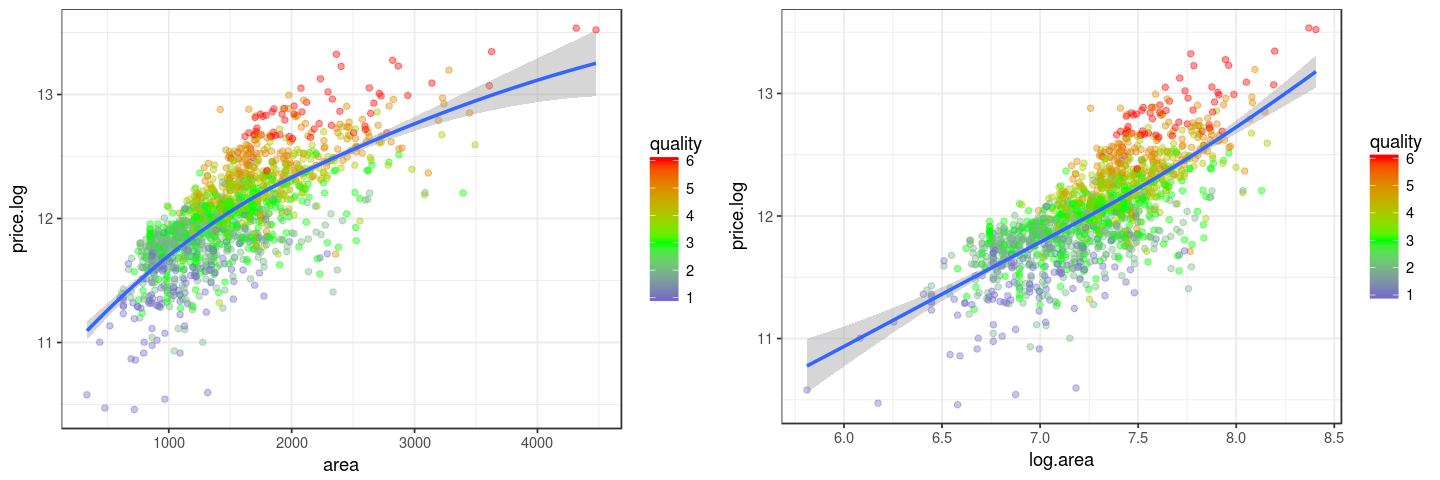

In [40]:
p1 <- 
    trainset %>% rename(area=GrLivArea) %>%
    ggplot(aes(x=area, y=price.log)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    theme_bw()

p2 <- 
    trainset %>%
    ggplot(aes(x=log.area, y=price.log)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    theme_bw()

lm(price.log ~ GrLivArea, data=df) %>% glance
lm(price.log ~ log.area, data=df) %>% glance

options(repr.plot.width = 12, repr.plot.height = 4)
grid.arrange(p1, p2, layout_matrix=rbind(c(1, 2)))

r.squared adj.r.squared sigma     statistic p.value       df logLik   
1 0.5437991 0.5434858     0.2700711 1735.576  2.079661e-250 2  -159.1875
  AIC      BIC      deviance df.residual
1 324.3749 340.2294 106.1983 1456

term        estimate  std.error  statistic p.value      
1 (Intercept) 5.5415392 0.15576391 35.57653  5.072263e-200
2 log.area    0.8921619 0.02141518 41.66025  2.079661e-250

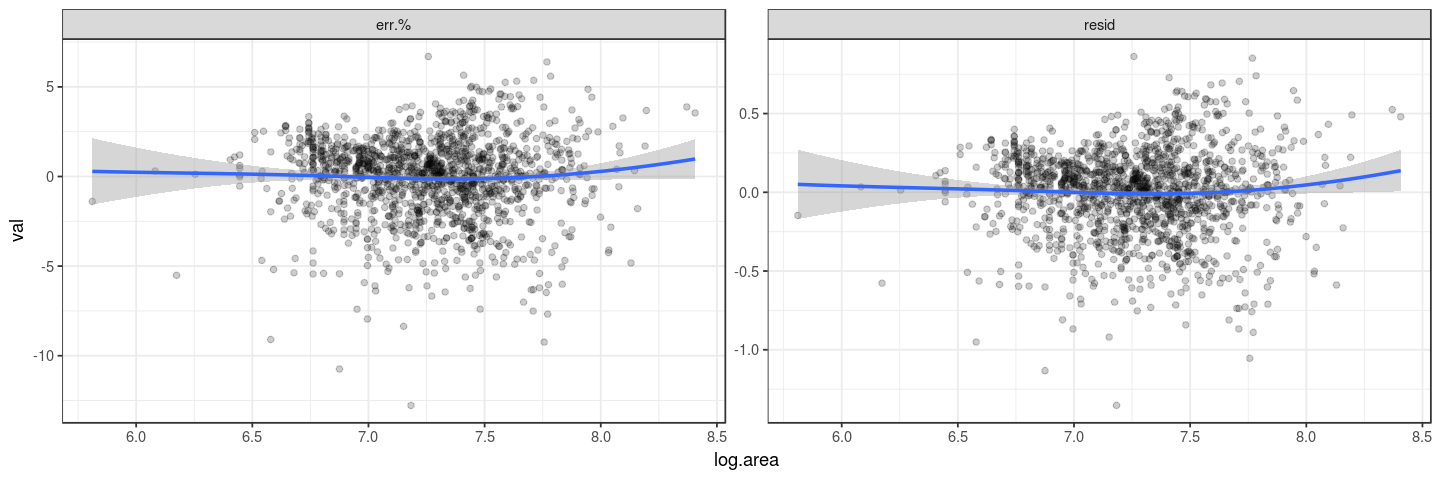

In [41]:
mod <- lm(price.log ~ log.area, data=trainset)
mod %>% glance
mod %>% tidy

mod %>% 
    augment %>% 
    select(price.log, log.area, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / price.log) %>%
    gather(name, val, -price.log, -log.area) %>%
    ggplot(aes(x=log.area, y=val)) +
    geom_point(alpha=0.2) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

In [43]:
cor.to.log.area <-
    trainset %>%
    select(-GrLivArea, -log.area, -OverallQual, -quality, -price, -price.log, -sq.feat.price) %>%
    cor(trainset$log.area) %>% 
    as.data.frame %>% 
    rownames_to_column('var.name') %>%
    rename(corr.to.log.area=V1)

cor.to.quality <-
    trainset %>%
    select(-GrLivArea, -log.area, -OverallQual, -quality, -price, -price.log, -sq.feat.price) %>%
    cor(trainset$quality) %>% 
    as.data.frame %>% 
    rownames_to_column('var.name') %>%
    rename(corr.to.quality=V1)

x <- 
    cor.to.log.area %>%
    left_join(cor.to.quality, by='var.name') %>%
    left_join(log.price.vs.vars, by='var.name') %>%
    filter(r2.log > 0.1) %>%
    mutate(
        `r2.log/corr.to.quality` = r2.log/corr.to.quality,
        `r2.log/corr.to.log.area` = r2.log/corr.to.log.area
    ) %>%
    mutate_if(is.numeric, funs(round(., 3)))

x %>% arrange(desc(`r2.log/corr.to.quality`)) %>% head
x %>% arrange(desc(`r2.log/corr.to.log.area`)) %>% head

var.name     corr.to.log.area corr.to.quality r2    r2.log r2.sq.feat
1 X1stFlrSF    0.539            0.463           0.399 0.385  0.093     
2 Neighborhood 0.478            0.701           0.523 0.572  0.292     
3 TotalBsmtSF  0.419            0.528           0.424 0.419  0.229     
4 GarageArea   0.467            0.556           0.396 0.431  0.170     
5 GarageCars   0.497            0.602           0.411 0.464  0.166     
6 BsmtFinSF1   0.130            0.210           0.168 0.154  0.201     
  r2.log/corr.to.quality r2.log/corr.to.log.area
1 0.831                  0.714                  
2 0.816                  1.197                  
3 0.793                  1.001                  
4 0.776                  0.922                  
5 0.771                  0.934                  
6 0.732                  1.185

var.name     corr.to.log.area corr.to.quality r2    r2.log r2.sq.feat
1 YearBuilt    0.232            0.578           0.274 0.345  0.317     
2 Neighborhood 0.478            0.701           0.523 0.572  0.292     
3 BsmtFinSF1   0.130            0.210           0.168 0.154  0.201     
4 BsmtQual     0.387            0.687           0.454 0.455  0.302     
5 BsmtExposure 0.127            0.306           0.147 0.143  0.181     
6 BsmtFinType1 0.213            0.489           0.209 0.228  0.214     
  r2.log/corr.to.quality r2.log/corr.to.log.area
1 0.597                  1.488                  
2 0.816                  1.197                  
3 0.732                  1.185                  
4 0.662                  1.177                  
5 0.467                  1.129                  
6 0.467                  1.071

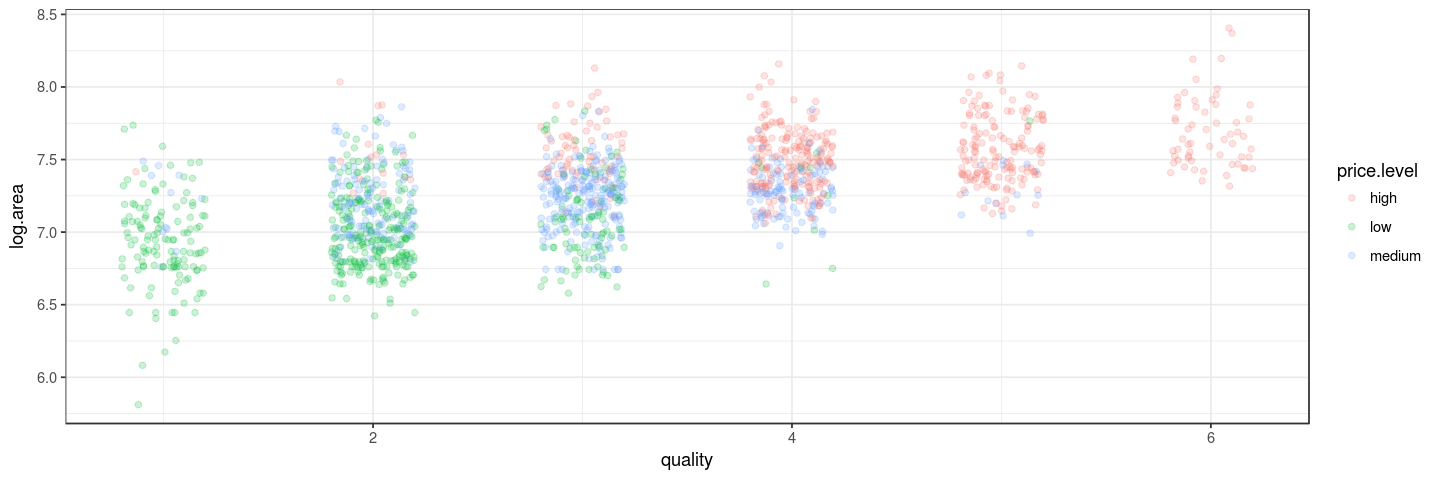

In [44]:
trainset %>%
    mutate(
        price.level = case_when(
            price.log <= quantile(price.log, 0.33) ~ 'low',
            price.log > quantile(price.log, 0.33)  & 
                price.log < quantile(price.log, 0.66) ~ 'medium',
            TRUE ~ 'high'
        )
    ) %>%
    ggplot() +
    geom_jitter(aes(x=quality, y=log.area, color=price.level), alpha=0.2, width=0.2, height=0) +
    theme_bw()

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.754635  0.7542977     0.1981324 2237.47   0       3  292.9283 -577.8566
  BIC       deviance df.residual
1 -556.7173 57.11814 1455

term        estimate  std.error   statistic p.value      
1 (Intercept) 8.0310149 0.134221393 59.83409   0.000000e+00
2 log.area    0.4741085 0.019662604 24.11219  2.383194e-108
3 quality     0.1765286 0.004992495 35.35879  3.470013e-198

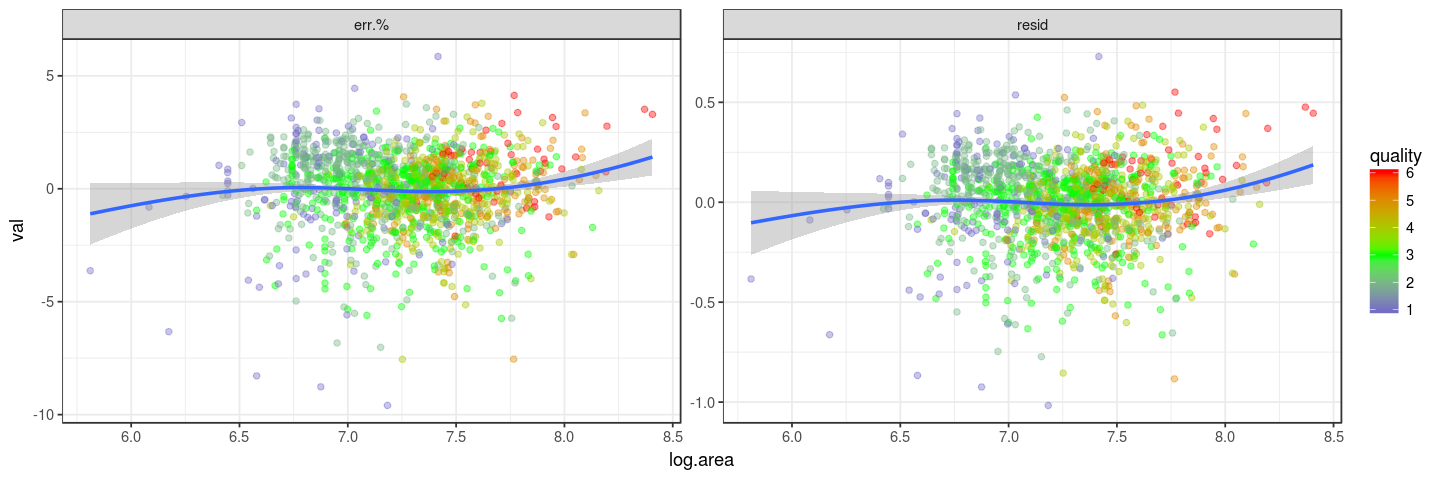

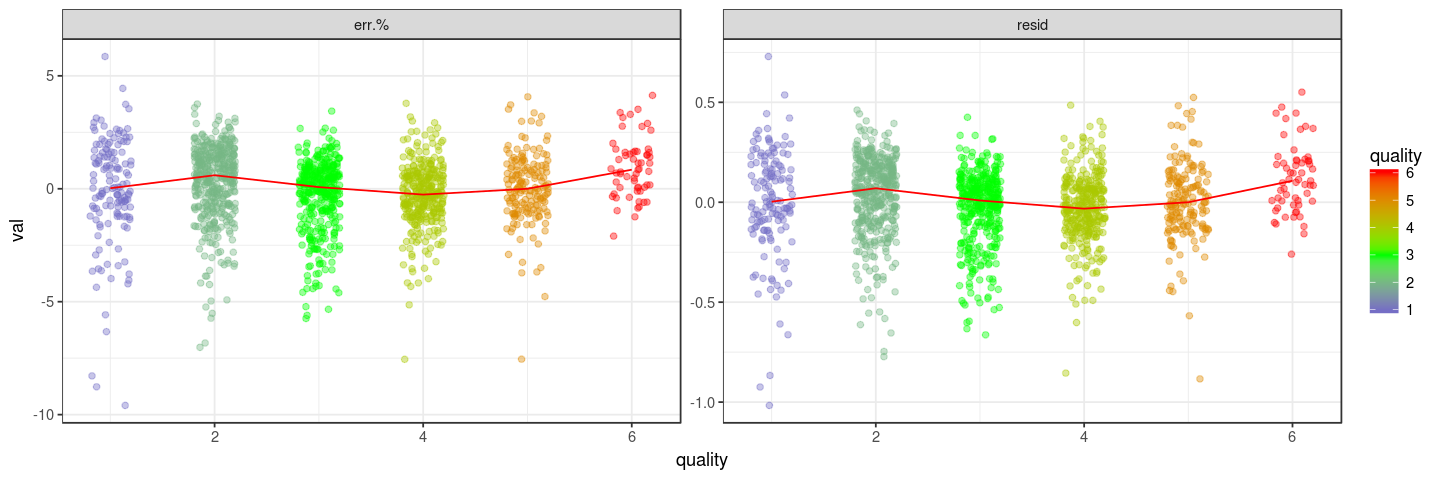

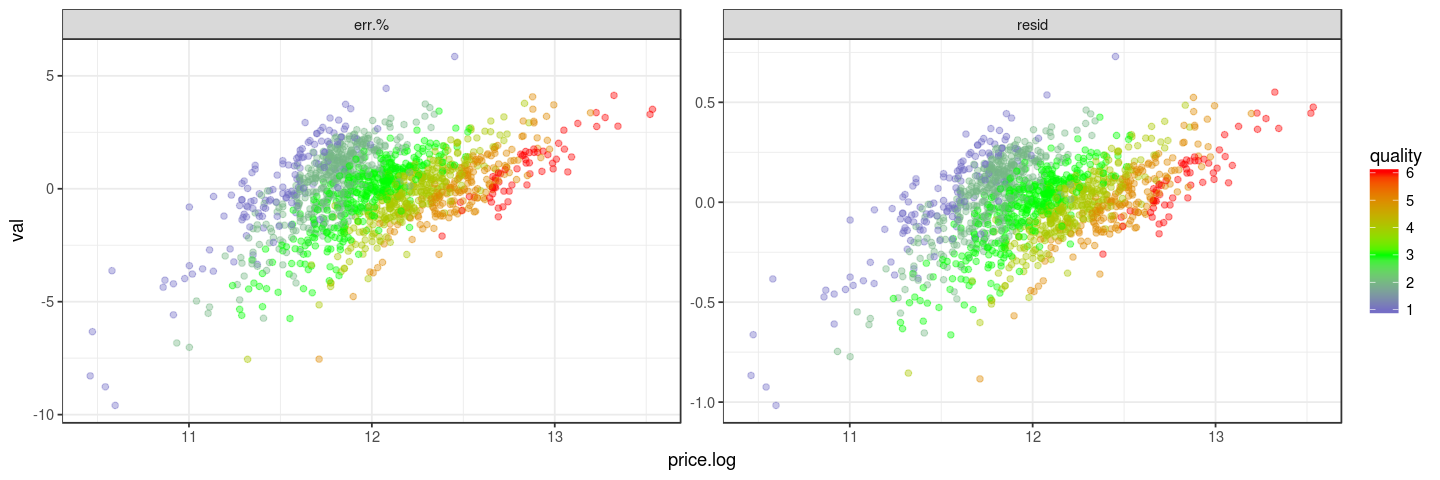

In [47]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(price.log ~ log.area + quality, data=trainset)

mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    select(price.log, log.area, quality, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / price.log) %>%
    gather(name, val, -price.log, -log.area, -quality)

df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot() +
    geom_point(aes(x=price.log, y=val, color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.7587705 0.7582728     0.1965231 1524.485  0       4  305.3202 -600.6404
  BIC       deviance df.residual
1 -574.2163 56.15542 1454

term        estimate   std.error   statistic p.value      
1 (Intercept) 8.14175132 0.134966127 60.324405  0.000000e+00
2 log.area    0.47590180 0.019506206 24.397456 1.759080e-110
3 quality     0.08762434 0.018482575  4.740916  2.336109e-06
4 quality2    0.01343688 0.002691306  4.992699  6.673111e-07

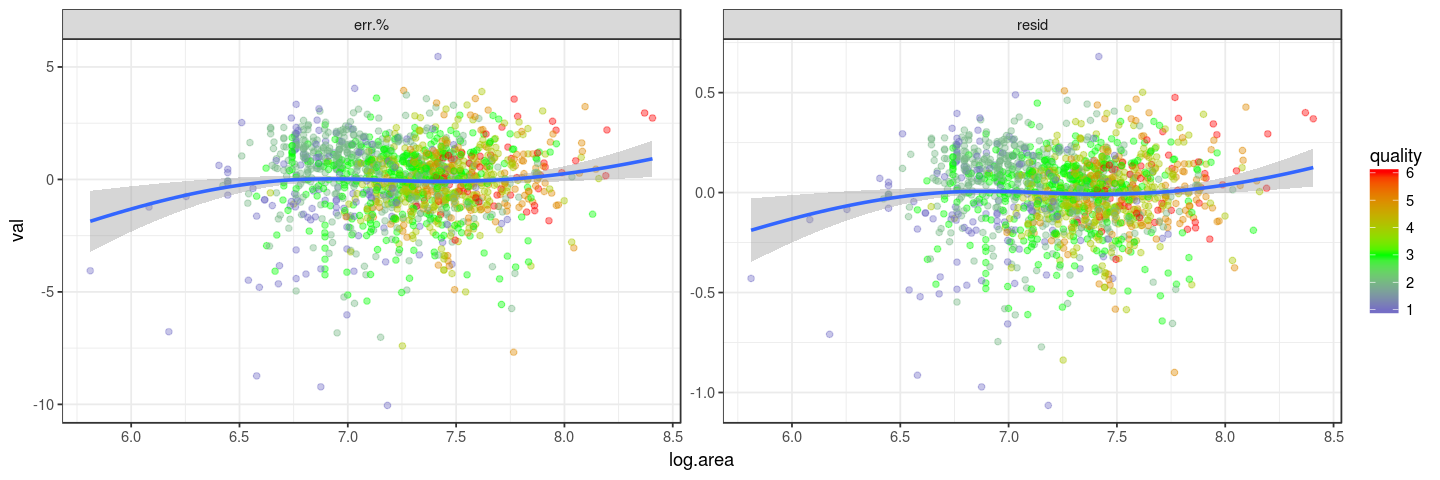

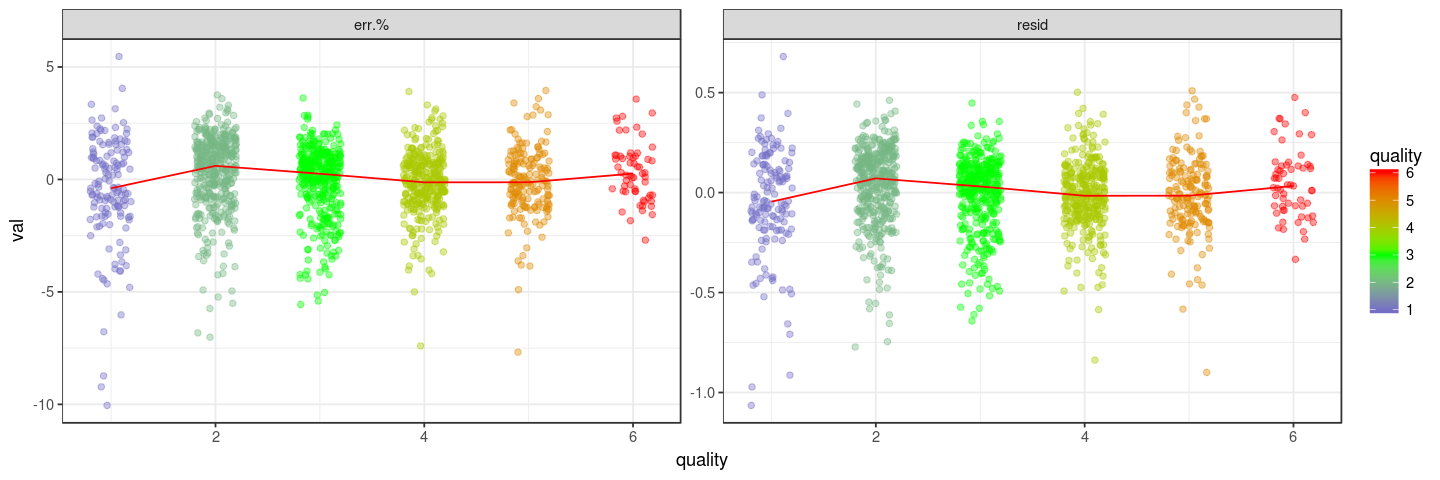

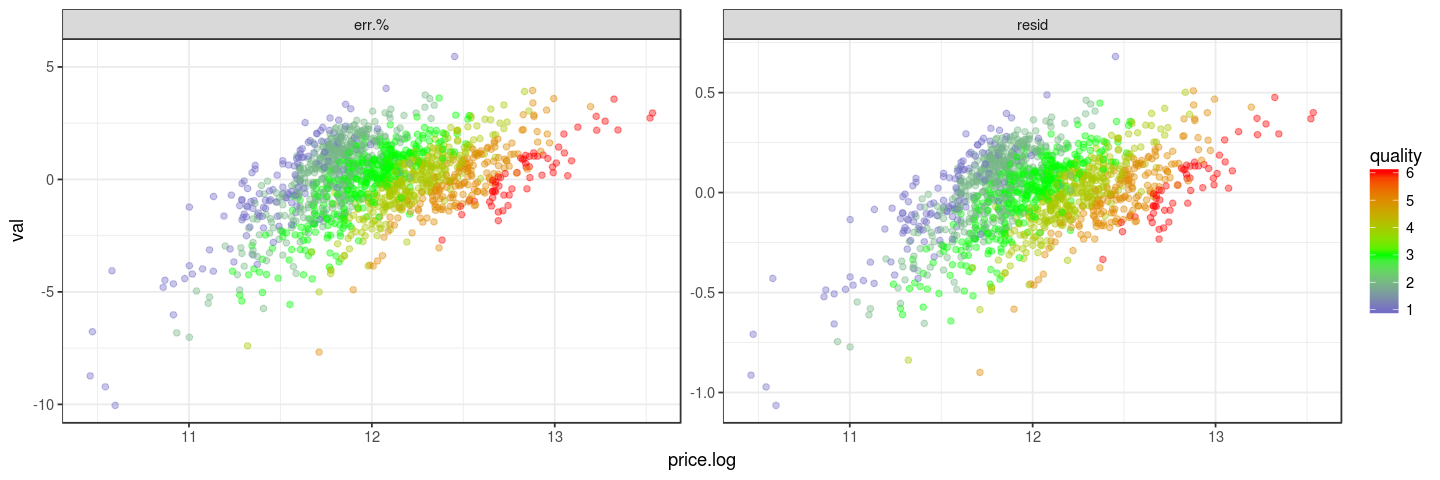

In [50]:
options(repr.plot.width = 12, repr.plot.height = 4)

mod <- lm(price.log ~ log.area + quality + quality2, data=trainset %>% mutate(quality2 = quality^2))

mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    select(price.log, log.area, quality, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / price.log) %>%
    gather(name, val, -price.log, -log.area, -quality)

df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot() +
    geom_point(aes(x=price.log, y=val, color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

r.squared adj.r.squared sigma    statistic p.value       df logLik    AIC    
1 0.3446195 0.3441694     0.323703 765.6103  9.084861e-136 2  -423.2915 852.583
  BIC      deviance df.residual
1 868.4375 152.565  1456

term        estimate    std.error    statistic p.value      
1 (Intercept) -3.29527359 0.5537139284 -5.95122   3.329151e-09
2 YearBuilt    0.00777148 0.0002808664 27.66966  9.084861e-136

r.squared adj.r.squared sigma   statistic p.value       df logLik   AIC    
1 0.4076478 0.4068335     0.30785 500.6544  3.564239e-166 3  -349.579 707.158
  BIC      deviance df.residual
1 728.2973 137.8927 1455

term        estimate      std.error    statistic p.value     
1 (Intercept)  3.862348e+02 3.131074e+01  12.33554 2.530705e-33
2 YearBuilt   -3.894084e-01 3.192224e-02 -12.19866 1.170740e-32
3 YearBuilt2   1.012188e-04 8.134896e-06  12.44254 7.570087e-34

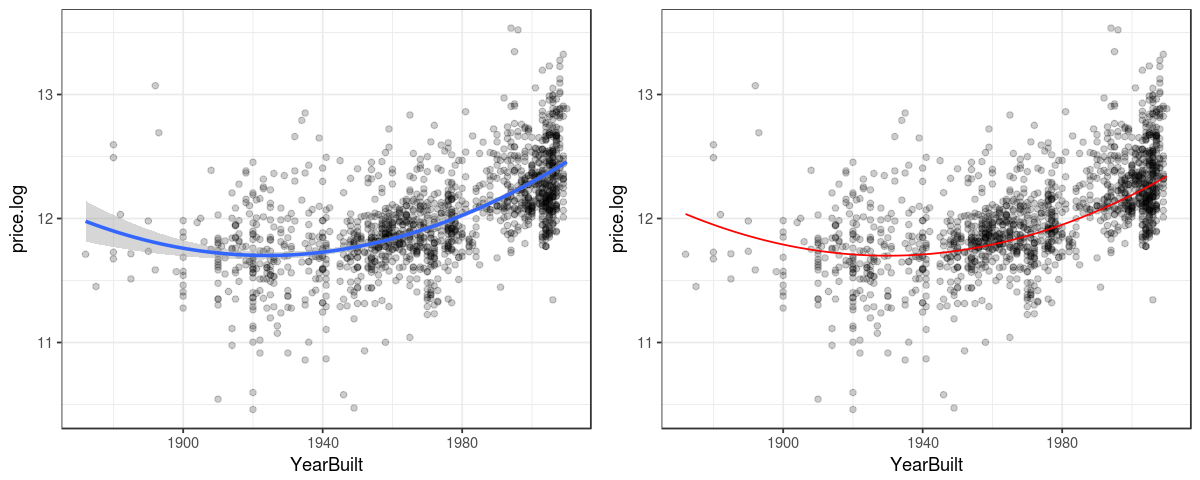

In [51]:
mod1 <- lm(price.log ~ YearBuilt, data=trainset) 
mod1 %>% glance
mod1 %>% tidy

mod2 <- lm(price.log ~ YearBuilt + YearBuilt2, data=trainset %>% mutate(YearBuilt2 = YearBuilt^2))
mod2 %>% glance
mod2 %>% tidy

p1 <- 
    trainset %>%
    ggplot(aes(x=YearBuilt, y=price.log)) +
    geom_point(alpha=0.2) +
    geom_smooth(method = "loess", span = 1) +
    theme_bw()

p2 <-
    trainset %>%
    ggplot(aes(x=YearBuilt, y=price.log)) +
    geom_point(alpha=0.2) +
    stat_function(fun = function (x) { 11.7 + 0.0001*(x - 1930)^2 }, colour = "red") +
    theme_bw()

options(repr.plot.width = 10, repr.plot.height = 4)
grid.arrange(p1, p2, layout_matrix=rbind(c(1, 2)))

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.7981759 0.7976203     0.1798185 1436.584  0       5  435.3388 -858.6775
  BIC       deviance df.residual
1 -826.9686 46.98232 1453

term        estimate      std.error    statistic p.value      
1 (Intercept) -7.355761e+01 2.072396e+01 -3.549399  3.984138e-04
2 log.area     5.327632e-01 1.815045e-02 29.352624 4.287568e-149
3 quality      1.310197e-01 5.938149e-03 22.064063  2.798099e-93
4 year         7.971236e-02 2.117362e-02  3.764702  1.733940e-04
5 year2       -1.950972e-05 5.410639e-06 -3.605807  3.217093e-04

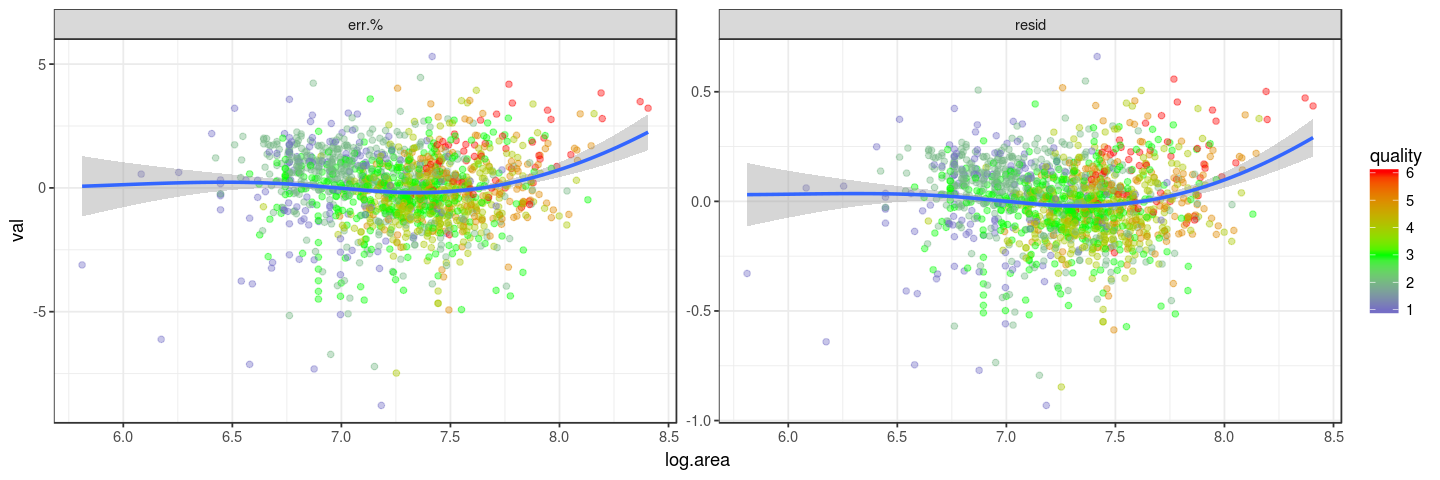

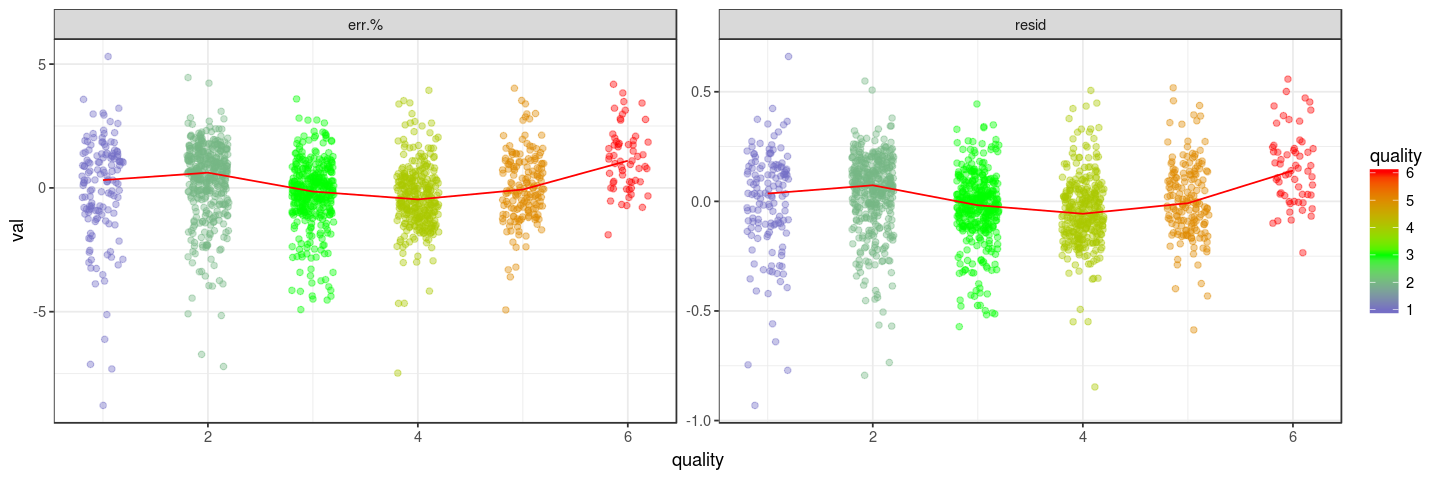

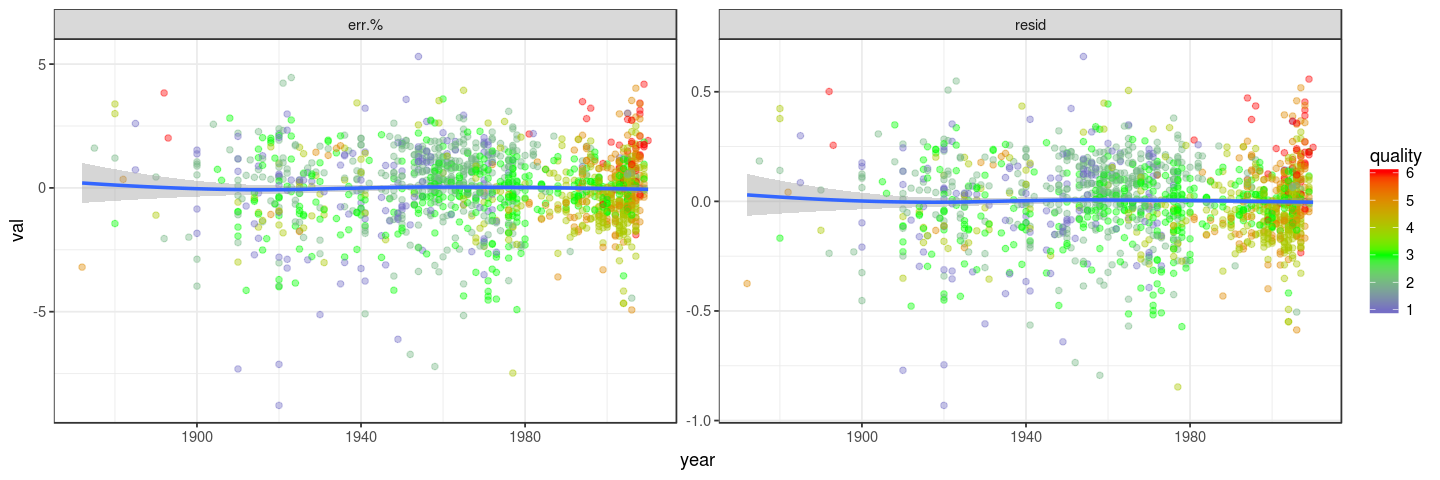

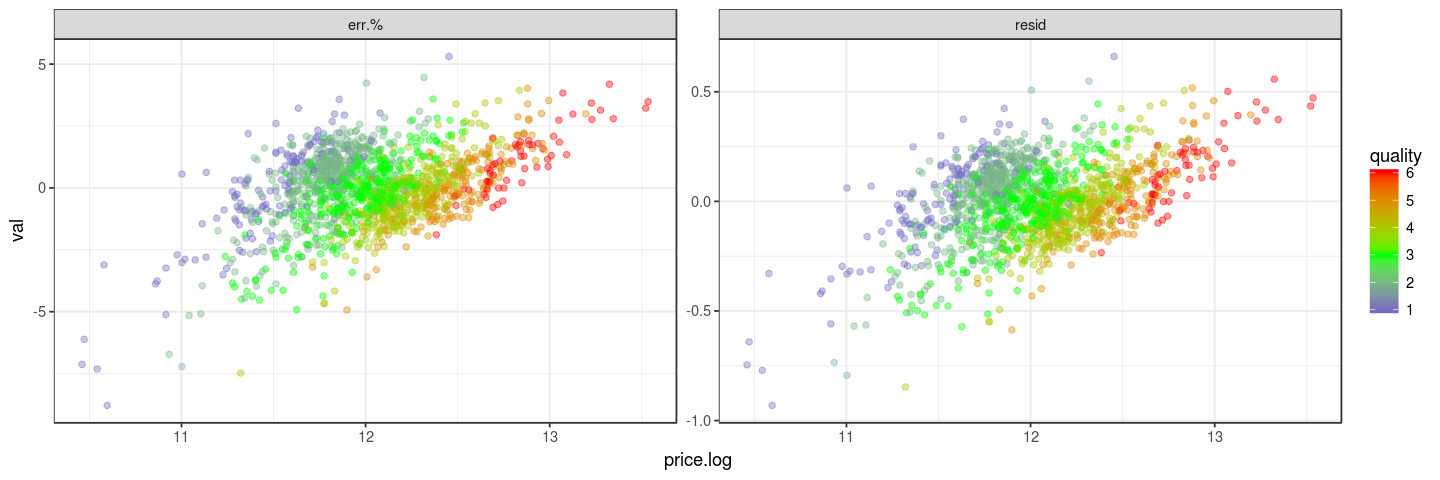

In [52]:
options(repr.plot.width = 12, repr.plot.height = 4)

df <-
    trainset %>% rename(year=YearBuilt) %>%
    mutate(year2 = year*year)

mod <- lm(price.log ~ log.area + quality + year + year2, data=df)
mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    select(log.area, quality, year, year2, price.log, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / price.log) %>%
    gather(name, val, -price.log, -log.area, -quality, -year, -year2)


df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=year, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot() +
    geom_point(aes(x=price.log, y=val, color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

r.squared adj.r.squared sigma     statistic p.value df logLik   AIC      
1 0.8221211 0.8215086     0.1688727 1342.172  0       6  527.4069 -1040.814
  BIC      deviance df.residual
1 -1003.82 41.40814 1452

term        estimate      std.error    statistic p.value      
1 (Intercept) -8.819613e+01 1.949061e+01 -4.525056  6.530337e-06
2 log.area     4.817378e-01 1.743195e-02 27.635332 1.980469e-135
3 quality      1.063733e-01 5.848691e-03 18.187534  9.441095e-67
4 year         9.665210e-02 1.992163e-02  4.851615  1.356494e-06
5 year2       -2.421977e-05 5.092443e-06 -4.756022  2.170774e-06
6 hood         3.346765e-01 2.393837e-02 13.980758  9.150030e-42

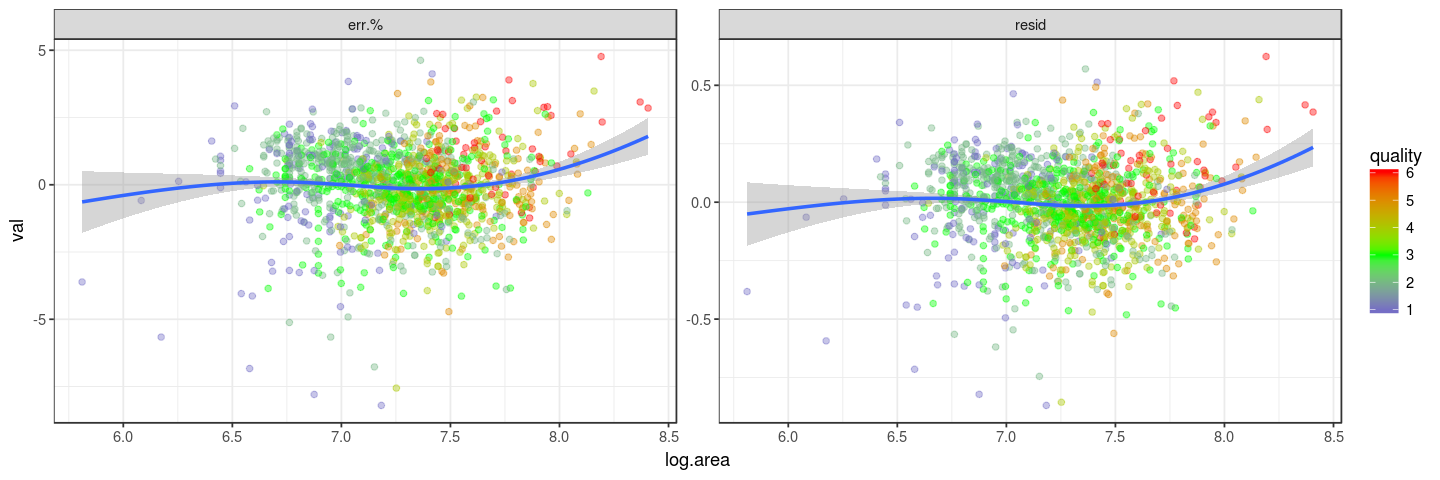

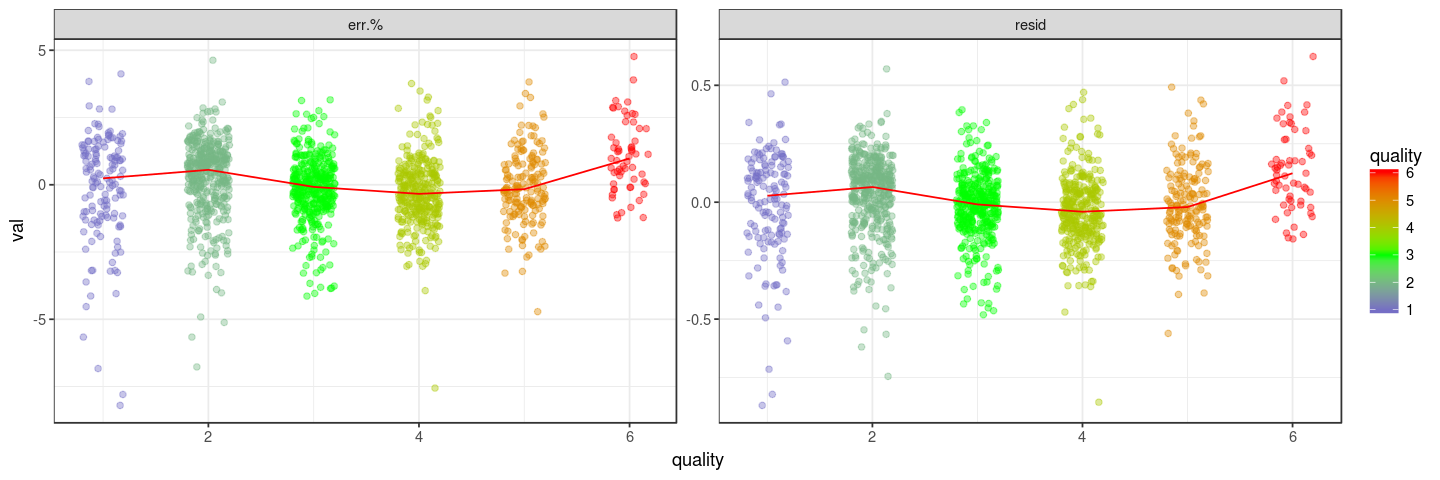

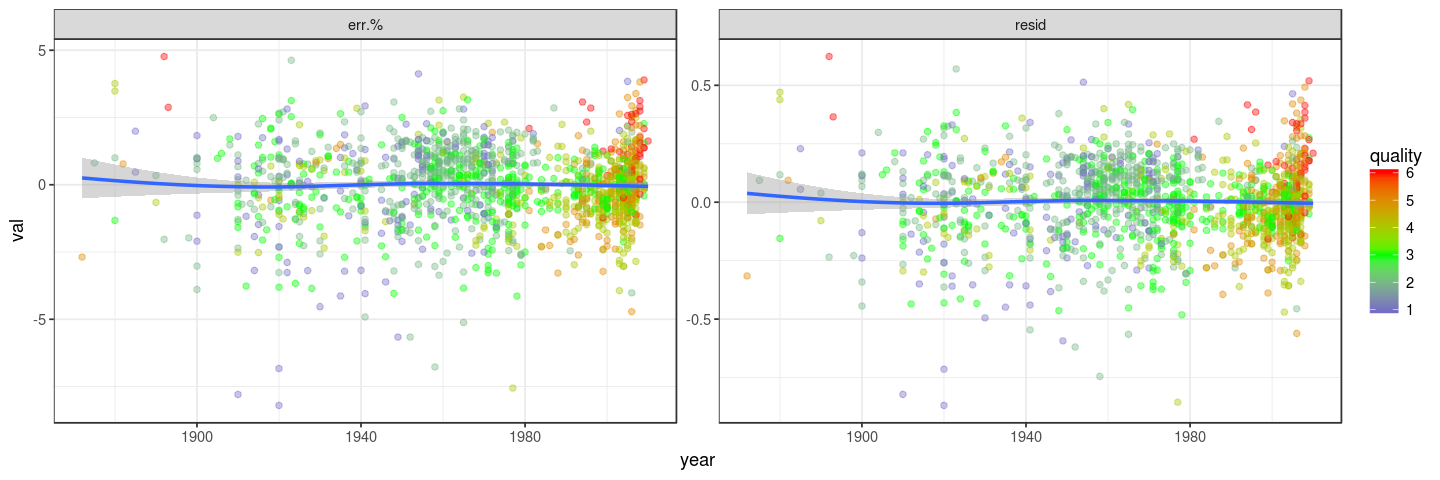

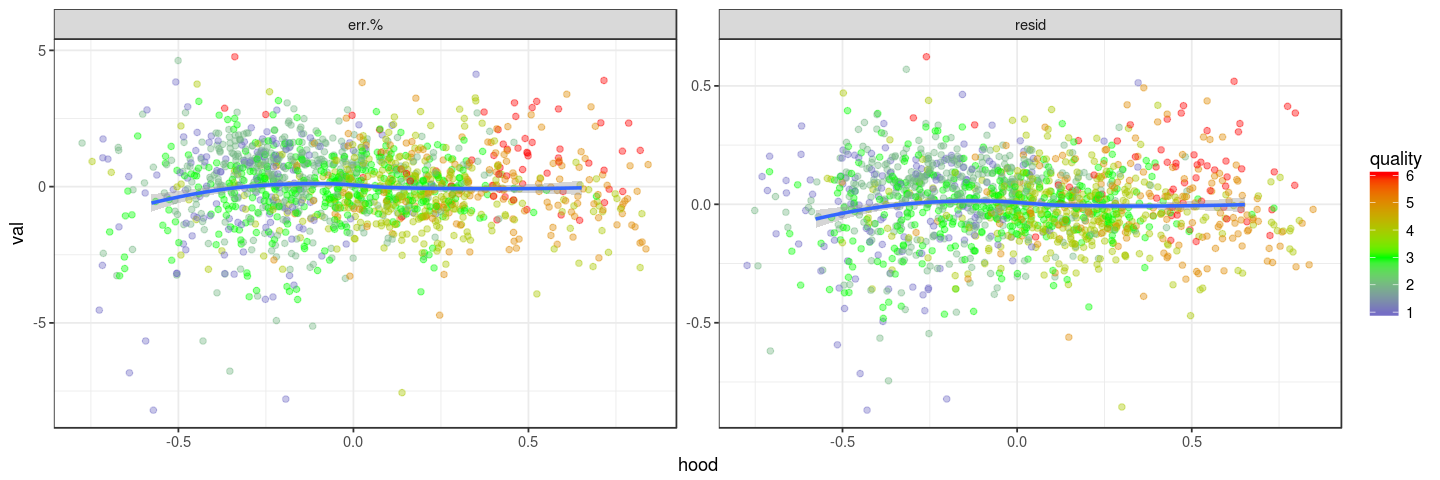

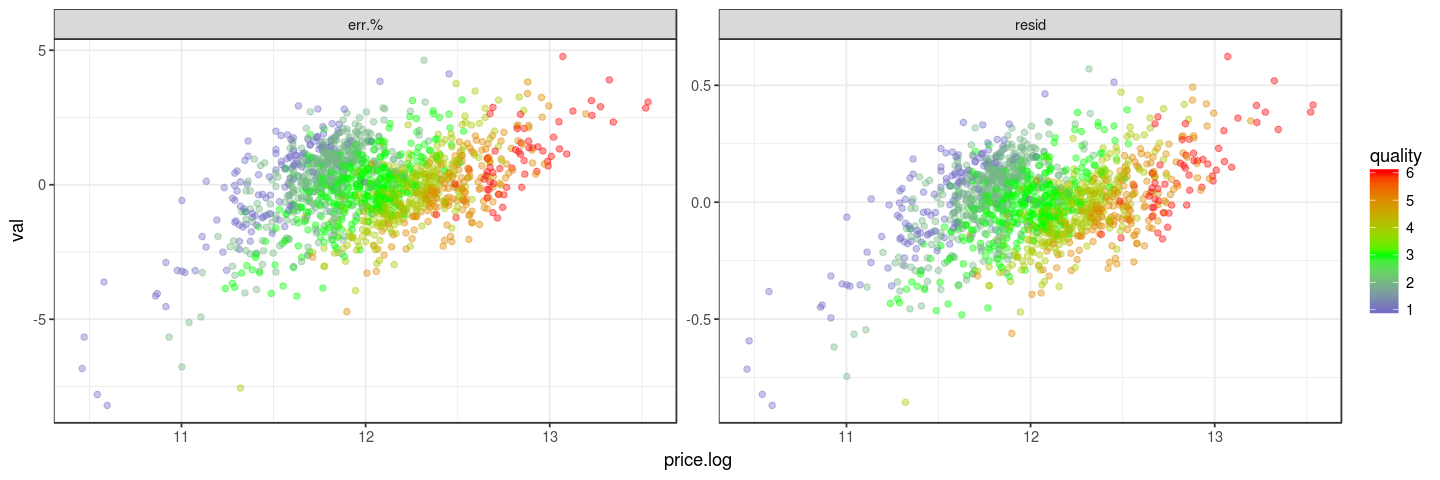

In [58]:
options(repr.plot.width = 12, repr.plot.height = 4)

df <-
    trainset %>% 
    rename(year=YearBuilt, hood=Neighborhood) %>%
    mutate(year2 = year*year)

mod <- lm(price.log ~ log.area + quality + year + year2 + hood, data=df)
mod %>% glance
mod %>% tidy

df <- 
    mod %>% 
    augment %>% 
    select(log.area, quality, year, year2, hood, price.log, resid=.resid) %>%
    mutate(`err.%` = 100 * resid / price.log) %>%
    gather(name, val, -price.log, -log.area, -quality, -year, -year2, -hood)


df %>% 
    ggplot(aes(x=log.area, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=quality, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    stat_summary(fun.y = median, geom="line", colour = "red") +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=year, y=val)) +
    geom_point(aes(color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot(aes(x=hood, y=val)) +
    geom_jitter(aes(color=quality), alpha=0.4, width=0.2, height=0) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    geom_smooth(method = "loess", span = 1) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()

df %>% 
    ggplot() +
    geom_point(aes(x=price.log, y=val, color=quality), alpha=0.4) +
    scale_colour_gradient2(low = "blue", mid = "green", high = "red", midpoint = 3) +
    facet_wrap(~name, ncol=2, scales="free") +
    theme_bw()